In [16]:
import json
import pandas as pd
import gensim.downloader as api
from sklearn.utils import shuffle
import zipfile
import sys
import requests, io
import re 
import random
import numpy as np
import matplotlib.pyplot as plt

import json
import pandas as pd
import pymorphy2
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import gensim.models as models
from gensim.models import Word2Vec
from gensim.models import FastText
from gensim.models import KeyedVectors
import gensim.downloader as api
from sklearn.utils import shuffle
import zipfile
import sys
import requests, io
import re 
import random
import numpy as np
import matplotlib.pyplot as plt
from nltk.tokenize import sent_tokenize


nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Andrey\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Andrey\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
def preprocess(text:str, stop_words, punctuation_marks, morph):
    tokens = word_tokenize(text.lower())
    preprocessed_text = []
    for token in tokens:
        if token not in punctuation_marks:
            lemma = morph.parse(token)[0].normal_form
            if re.match(r'(\d.|\d)', lemma) is None:
                if lemma not in stop_words:
                    preprocessed_text.append(lemma)
    return preprocessed_text

def read_json(path: str):
    file = open(path)
    data = json.load(file)
    return pd.DataFrame(data)

def get_states(sim, df, match_threshold):
    (TP, FP, FN, TN) = (0, 0, 0, 0)
    for i in range(len(sim)):
        if df['need_match'][i:i+1].item():
            if sim[i] >= match_threshold: 
                TP += 1
            else:
                FN += 1
        else:
            if sim[i] >= match_threshold: 
                FP += 1
            else:
                TN += 1
    
    return (TP, FP, FN, TN)
        

def calc_f1_score(sim, df, match_threshold):
    (TP, FP, FN, TN) = get_states(sim, df, match_threshold)
#     print(TP, FP, FN, TN)
    return round(float(2*TP / (2*TP + FP + FN)), 3)

def calc_accuracy(sim, df, match_threshold):
    (TP, FP, FN, TN) = get_states(sim, df, match_threshold)
    return round(float((TP + TN) / (TP + TN + FP + FN)), 3)

class ModelResearcher:
    def __init__(self):
        self.model = None
    
    def load_transformer(self, name):
        self.model = SentenceTransformer.load(name)
    
    def preprocess_and_save(self, data_df: pd.DataFrame, path, text_field='text') -> pd.DataFrame:
        # for preprocessing dataset. Use it only in critical cases cause it's too slow on big datasets
        data_df['preprocessed_' + text_field] = data_df.apply(lambda row: preprocess(row[text_field], punctuation_marks, stop_words, morph), axis=1)
        data_df_preprocessed = data_df.copy()
        data_df_preprocessed = data_df_preprocessed.drop(columns=[text_field], axis=1)
        data_df_preprocessed.reset_index(drop=True, inplace=True)
        if path is not None:
            data_df_preprocessed.to_json(path)
        return data_df_preprocessed
    
    
    def preprocess_and_save_pairs(self, data_df: pd.DataFrame, path, text_field_1, text_field_2) -> pd.DataFrame:
        data_df['preprocessed_' + text_field_1] = data_df.apply(lambda row: preprocess(row[text_field_1], punctuation_marks, stop_words, morph), axis=1)
        data_df['preprocessed_' + text_field_2] = data_df.apply(lambda row: preprocess(row[text_field_2], punctuation_marks, stop_words, morph), axis=1)
        data_df_preprocessed = data_df.copy()
        data_df_preprocessed = data_df_preprocessed.drop(columns=[text_field_1, text_field_2], axis=1)
        data_df_preprocessed.reset_index(drop=True, inplace=True)
        if path is not None:
            data_df_preprocessed.to_json(path)
        return data_df_preprocessed
    
    def train(self, data_df: pd.DataFrame, model="w2v"):            
        if model == "w2v":
            train_part = data_df['preprocessed_texts']
            self.model = gensim.models.Word2Vec(sentences=train_part, min_count=5, vector_size=50, epochs=5)
            self.model.save('w2v')
        elif model == "fast_text":
            train_part = data_df['preprocessed_texts'].tolist()
            self.model = gensim.models.FastText(vector_size=50, min_count=5)
            self.model.build_vocab(corpus_iterable=train_part)
            self.model.train(corpus_iterable=train_part, total_examples=len(train_part), epochs=5)
            self.model.save('fastText')
        return

                    
    
    def predict_sentences_similarity(self, sentences_1: pd.Series, sentences_2: pd.Series):
        if sentences_1.size != sentences_2.size:
            return None
        else:
            if self.model is not None:
                sentences_sim = np.zeros(sentences_1.size)
                sz = sentences_1.size
                for i in range(sz): 
                    sentences_1_words = [w for w in sentences_1[i] if w in self.model.wv.index_to_key]
                    sentences_2_words = [w for w in sentences_2[i] if w in self.model.wv.index_to_key]
                    sim = self.model.wv.n_similarity(sentences_1_words, sentences_2_words)
                    sentences_sim[i] = sim
                
                return sentences_sim
            else:
                return None
        
    def get_train_test_dfs_for_f1(self, df_match, df_unmatch): 
        df_match = shuffle(df_match)
        df_unmatch = shuffle(df_unmatch)
        
        df_train_f1 = pd.concat([pd.DataFrame(df_match[0:len(df_match) // 2]), pd.DataFrame(df_unmatch[0:len(df_unmatch) // 2])], axis=0)
        df_test_f1 = pd.concat([pd.DataFrame(df_match[len(df_match) // 2 : ]), pd.DataFrame(df_unmatch[len(df_unmatch) // 2 : ])], axis=0)
        return (df_train_f1, df_test_f1)
    
    
    def get_optimal_threshold(self, sentences_1: pd.Series, sentences_2: pd.Series, df, step=0.02):
        if sentences_1.size != sentences_2.size or self.model is None:
            return None
        else:
            threshold = 0
            thresholds = []
            max_ = 0
            h = step
            steps = np.linspace(0, 1, num=int(1/h))
            steps = np.round(steps, 2)
            for i in steps:
                sim =  self.predict_sentences_similarity( sentences_1, sentences_2)
                threshold = calc_f1_score(sim, df, h)
                print(h, threshold)
                thresholds.append(threshold)
                if threshold > max_:
                    max_ = threshold
                h += step
            plt.plot(steps, thresholds)
            plt.figure(figsize=(10,3))
            plt.show()
            
            return max_

punctuation_marks = ['!', ',', '(', ')', ';', ':', '-', '?', '.', '..', '...', "\"", "/", "\`\`", "»", "«" ]
stop_words = stopwords.words("russian")
morph = pymorphy2.MorphAnalyzer()

In [4]:
from sentence_transformers import SentenceTransformer

In [5]:
# model = SentenceTransformer('DeepPavlov/rubert-base-cased')

In [6]:
# model.save('./models/Pavlov-rubert')

In [7]:
model = SentenceTransformer.load('./models/Pavlov-rubert')

In [8]:
match_unmatch_df = read_json('./dataset.json')

In [9]:
df_match = match_unmatch_df[ match_unmatch_df['need_match'] == True][:-2]
df_unmatch = match_unmatch_df[match_unmatch_df['need_match'] == False]

modelResearcher_rubert = ModelResearcher()
modelResearcher_rubert.load_transformer('./models/Pavlov-rubert')
df_train_f1, df_test_f1 = modelResearcher_rubert.get_train_test_dfs_for_f1(df_match, df_unmatch)

In [10]:
print('df_train: {} of {}'.format(df_train_f1['id_rp'].size, match_unmatch_df ['id_rp'].size))
print('df_test: {} of {}'.format(df_test_f1['id_rp'].size, match_unmatch_df['id_rp'].size))

df_train: 22 of 46
df_test: 22 of 46


### Наивные методы

0
Optimal threshold: 0.667


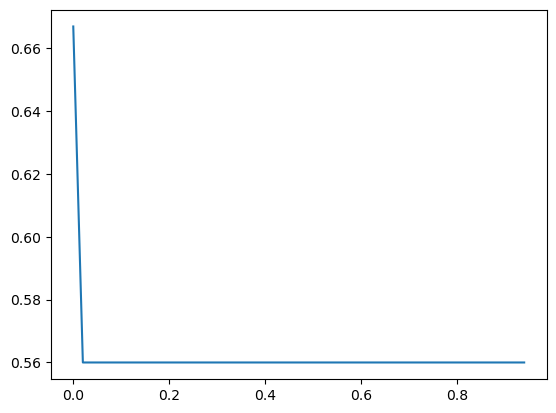

<Figure size 1000x300 with 0 Axes>

In [20]:
# дурацкие методы

import random

def match_naive(text_1, text_2):
    return int((len(text_1) + len(text_2)) % 2 == 0)

def match_rand(text_1, text_2):
    return int(bool(random.getrandbits(1)))

threshold = 0
thresholds = []
max_ = 0
print(max_)
step = 0.02 
from_ = 0.0
to = 0.94
h = from_
steps = np.linspace(from_, to, num=int((to - from_)/step))
steps = np.round(steps, 2)
for i in steps:
    sim = []
    for text_rp, text_proj in zip(df_train_f1['text_rp'], df_train_f1['text_proj']):
        sim += [match_naive(text_rp, text_proj)] 
    threshold = calc_f1_score(sim, df_train_f1, h)
    thresholds.append(threshold)
    # print(threshold)
    if threshold > max_:
        max_ = threshold
        # print(max_, threshold)
    h += step

print(f'Optimal threshold: {max_}')
plt.plot(steps, thresholds)
plt.figure(figsize=(10,3))
plt.show()

### Сравнить каждое предложение текста_1 и текста_2, и оценить каждое предложение по топ-5 совпадений в другом тексте

In [65]:
import re


def sent_preprocess(text:str):
    preprocessed_text = sent_tokenize(text)
    for i in range(len(preprocessed_text)):
        res = re.sub(r'([^\w\s])|([0-9]+)', '', preprocessed_text[i])
        # res = re.sub(r'', '' ,  res)
        preprocessed_text[i] = res
    
    preprocessed_text = list(filter(lambda sentence: sentence != '', preprocessed_text))
    

    return preprocessed_text

In [25]:
from sentence_transformers import SentenceTransformer
import sentence_transformers

modelR = SentenceTransformer('DeepPavlov/rubert-base-cased')

No sentence-transformers model found with name C:\Users\Andrey/.cache\torch\sentence_transformers\DeepPavlov_rubert-base-cased. Creating a new one with MEAN pooling.
Some weights of the model checkpoint at C:\Users\Andrey/.cache\torch\sentence_transformers\DeepPavlov_rubert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly id

In [59]:
df_train_f1, df_test_f1 = modelResearcher_rubert.get_train_test_dfs_for_f1(df_match, df_unmatch)
texts_rp = df_train_f1['text_rp'].reset_index().drop(labels='index', axis=1).squeeze()
texts_proj = df_train_f1['text_proj'].reset_index().drop(labels='index', axis=1).squeeze()

In [73]:

sentences_rp = sent_preprocess(texts_rp[0])
sentences_proj = sent_preprocess(texts_proj[0])

def comp(e):
    return e['cos_sim']

top_number = 5

for sentence_rp in sentences_rp:
    sentence_embedding_rp = modelR.encode(sentence_rp, convert_to_tensor=True)
    sim = []
    print(f'rp: {sentence_rp}')
    for sentence_proj in sentences_proj:
        sentence_embedding_proj = modelR.encode(sentence_proj, convert_to_tensor=True)
        sim += [{ 'proj': sentence_proj, 
                  'cos_sim': float(sentence_transformers.util.cos_sim( sentence_embedding_rp, sentence_embedding_proj))
                 }]
    
    sim.sort(key=comp, reverse=True)
    print(f'top {top_number} similarities:')
    count = top_number
    if(len(sim) < top_number):
        count = len(sim)
    for i in range(count):
        print('proj: {}\nsim: {}\n'.format(sim[i]['proj'], round(sim[i]['cos_sim'], 3)))


    
              
        
        
        
        

rp: Дисциплина Спецификация проектирование и архитектура программных систем предусматривает изучение методов выявления требований анализа функциональных и нефункциональных требований документирования требований и управления требованиями к программным системам обеспечивает формирование знаний об организации архитектуры программных систем и умений по проектированию программных систем с применением современных методов и средств
top 5 similarities:
proj: Задачи проекта реализуются в рамках отдела информационноаналитических систем департамента разработки бизнесприложений
sim: 0.738

proj: Построение аналитического решения включая корпоративное хранилище данных в рамках проектов по внедрению биллинговых систем и связанных с ними дополнительных систем
sim: 0.737

proj: В задачи Аналитика BI включается Анализ системисточников их архитектуры данных и бизнеспроцессов которые они автоматизируют
sim: 0.688

proj: В настоящее время компания ведет ряд крупных проектов по внедрению биллинговых систем